# Rješavanje problema trgovačkog putnika koristeći genetički algoritam
###### Trgovac želi obići $n$ gradova tako da svaki grad obiđe jednom te se na kraju vrati u početni grad. Kako odabrati put da bi prijeđena udaljenost bila najmanja?

In [525]:
import numpy as np
import random
import math
import networkx as nx
import matplotlib.pyplot as plt

### Problem trgovačkog putnika
Problem trgovačkog putnika možemo modelirati neusmjerenim težinskim grafom - čvorovi grafa su gradovi, bridovi su ceste između gradova, a težine bridova su udaljenosti gradova. Sada se problem trgovačkog putnika svodi na pronalaženje puta najmanje težine (put je šetnja u kojoj su svi vrhovi različiti).

In [456]:
def draw_graph(G, path = []):
    plt.rcParams['figure.figsize'] = [7, 7]
    po = nx.circular_layout(G)
    for e in G.edges():
        G[e[0]][e[1]]['color'] = 'grey'
    if np.array(path).any():
        for i in range(len(path)-1):
            G[int(path[i])][int(path[i+1])]['color'] = 'red'
        G[path[0]][path[len(path)-1]]['color'] = 'red'
    edge_colors = [G[e[0]][e[1]]['color'] for e in G.edges()]
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,po,edge_labels=labels)
    nx.draw(G,po, with_labels=True, node_size=1000, edge_color = edge_colors)

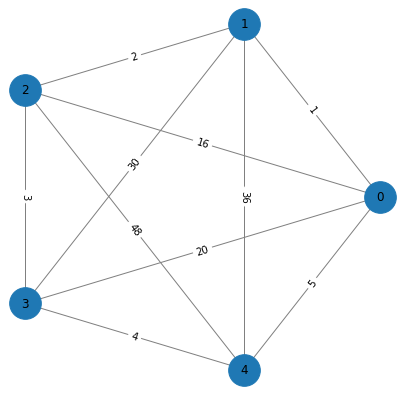

In [457]:
G = nx.complete_graph(5)
for i in range(4):
    G.add_edge(i,i+1, weight=i+1)
G.add_weighted_edges_from((i,j,(i+2)*(j+2)*2) for i in range(5) for j in range(5) if i!=j+1 and j!=i+1)
G.add_edge(0,4, weight=5)
draw_graph(G)

Problem trgovačkog putnika spada u klasu <a href = 'https://en.wikipedia.org/wiki/NP-completeness'> NP-potpunih problema</a>.  <br>
Jedan mogući algoritam, koji sigurno daje optimalan put, je provjera svih mogućih ruta (tzv. "brute force" metoda). Međutim, taj je algoritam eksponencijalne složenosti pa je neprektičan već za 20 gradova. <br>
Puno češći pristup je korištenje heurističkih algoritama. U ovoj bilježnici opisan je i implementiran jedan takav algoritam, tzv. genetički algoritam.

Klasa Map koja predstavlja graf s gradovima

In [322]:
class Map():
    def __init__(self, n, rand = False):
        self.num_of_cities = n
        if rand == True:
            self.xy = np.array([[random.uniform(0, 200), random.uniform(0,200)] for i in range(n)])
            self.distances = self.calculate_distances()
        else:
            self.xy = np.empty((self.num_of_cities, self.num_of_cities))
            self.distances = np.empty((self.num_of_cities, self.num_of_cities))     

    def calculate_distances(self):
        distances = np.empty((self.num_of_cities, self.num_of_cities))
        for i in range(self.num_of_cities):
            p = self.xy[i]
            for j in range(self.num_of_cities):
                q = self.xy[j]
                distances[i][j] = math.sqrt((p[0]-q[0])**2+(p[1]-q[1])**2)
        return distances    
    
    def draw_cities(self):
        plt.rcParams['figure.figsize'] = [10, 10]
        fig, ax1 = plt.subplots()
        ax1.set_title('Cities')
        ax1.scatter(self.xy[:,0], self.xy[:, 1], color = 'black')
        

## Genetički algoritmi
Genetički algoritmi vrsta su algoritama koji pripadaju klasi evolucijskih algoritama inspiriranih biološkom evolucijom. Ideja genetičkih algoritama inspirirana je teorijom evolucije Charlesa Darwina, odnosno biološkim pojavama poput prirodne selekcije, križanja koromosoma te mutacijama. <br>
Genetički algoritmi najčešće se koriste za optimizaciju, tj. tražanje najboljeg rješenja. Primjenjuju se u matematici i računarstvu, medicini, biologiji, forenzici, svemirskoj tehnologiji... <br>
Glavni dijelovi genetičkog algoritma su inicijalizacija populacije, selekcija, križanje i mutacija. Selekcija, križanje i mutacija nazivaju se i genetički operatori. Za genetički algoritam poptrebni su još i stopa mutacije i fitness funkcija.

#### Zanimljivi primjeri genetičkih algoritama

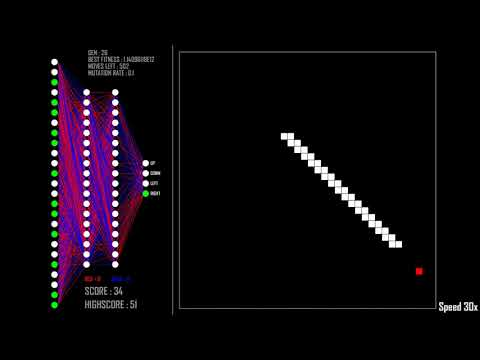

In [458]:
from IPython.display import YouTubeVideo
YouTubeVideo('zIkBYwdkuTk')

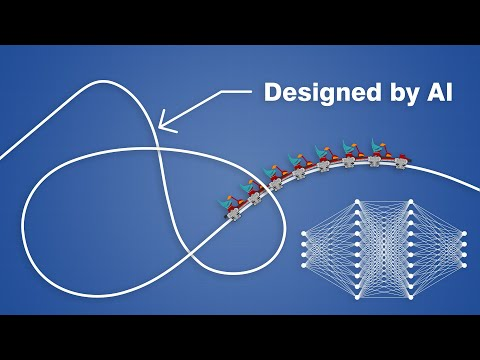

In [459]:
YouTubeVideo('4l5MGqrAItU')

### Populacija i jedinke

Populacija predstavlja skup od n kanditata koji se iterativno poboljšavaju. Svaki kanditat (jedinka u populaciji) ima skup svojstava koji se naziva kromosom. Kromosomi se sastoje od gena. <br>
Na početku algoritma, populacija je inicijalizirana nasumično (kromosomi su nasumično dodijeljeni kandidatima) te takva populacija čini prvu generaciju. Svaka iteracija stvara novu generaciju čiji kanditati imaju bolje kromosome od prethodne. Potrebno je odabrati strukturu za zapisivanje kromosoma.

U algoritmu za rješavanje problema trgovačkog putnika, jedinke od koji se sastoji populacija su dopušteni obilasci gradova (kroz svaki grad prolaze jednom i vraća se u početni grad), tj. dopuštene rute. Kromosom svake rute je lista gradova u redosljedu kojim se obilaze, tj. neka permutacija skupa $\{0, 1, \dots , num\_of\_cities -1\}$. <br>
Donja slika prikazuje kromosom rute koja počinje obilazak u gradu 4, pa odlazi u grad 8, pa u grad 0, ..., te na kraju u grad 2 iz kojeg se vraća u grad 4.

<img src='cromosome.png' width="600" height="600">

### Fitness funkcija
Označimo sa $P = (c_{i} , \dots , c_{n} )$ skup svih kandidata. Fitness funkcija $f : P \rightarrow \mathbb{R}$ predstavlja kvalitetu jedinke, odnosno koliko je jedinka blizu rješenja. Vrijednost $f(c_i)$ nazivamo fitness vrijednost jedinke $c_{i}$. <br>
Sama definicija fukncije ovisi o problemu čije se rješenje optimizira. Kvaliteta rješenja uvelike ovisi o odabiru fitness funkcije pa je odabir odgovarajuće fitness funkcije vrlo važan, no ponekad je pronalaženje takve funkcije vrlo težak zadatak. <br>
Za problem trgovačkog putnika, smatramo da je jednika, tj. ruta, bolja ako je pređena udaljenost na toj ruti manja. Zato za fitness vrijednost rute uzimamo $\frac{1}{\text{prijeđena udaljenost na ruti}}$. <br>

In [310]:
class Route():
    def __init__(self, n, graph):
        self.num_of_cities = n
        self.fitness = 0
        self.distance = 0
        self.map = graph
        self.path = np.random.permutation(self.num_of_cities)

    def calcDistance(self):
        for i in range(self.num_of_cities-1):
            self.distance += self.map.distances[self.path[i]][self.path[i+1]]
        self.distance += self.map.distances[self.path[0]][self.path[self.num_of_cities-1]]

    def calcFitness(self):
        self.calcDistance()
        self.fitness = 1/self.distance

    def clone(self):
        new_route = Route(self.num_of_cities, self.map)
        new_route.path = self.path
        return new_route
        

In [311]:
class  Population():
    def __init__(self, n, m, map):
        self.map = map
        self.num_of_routes = n
        self.num_of_cities = m
        self.routes = [Route(m,map) for i in range(n)]
        self.fitness = 0
        self.best_distance_in_generation = []
        self.best_route = ""

    def find_best_route(self):
        best_route = max(self.routes, key = lambda r: r.fitness)
        self.best_distance_in_generation.append(best_route.distance)
        self.best_route = best_route.clone()
        self.best_route.distance = best_route.distance
        
    def find_best_routes(self):
        best_routes = sorted(self.routes, key = lambda r: r.fitness, reverse = True)[:5]
        return [route.clone() for route in best_routes]

### Selekcija
U procesu selekcije, biraju se se najbolje jedinke iz trenutne generacije koje dalje sudjeluju u procesu križanja. Izbor najboljih jedinki temelji se na fitness vrijednosti svake jedinke. <br>
Selekcija se može provesti na više načina, a u ovom se algoritmu koristi tzv. <i>roulette wheel</i> selekcija.
Ideja metode je sljedeća: vjerojatnost odabira jednike $c_i$ proporcionalna je fitness vrijednosti $f(c_i)$.
Neka je $F = \displaystyle\sum_{i=1}^{n}f(c_{i})$ suma fitness vrijednosti svih jedinki populacije. <br>
Za $c_{i}\in P, i = 1, \dots , n$, definiramo $p_i = \frac{f(c)}{F}$ . Vrijednost $p_i$ predstavlja
vjerojatnost odabira jedinke $c_i$. <br>
Ova metoda može se vizualizirati pomoću kola za rulet (otud i naziv <i>roulette wheel</i> selekcija): Zamislimo da je kolo za rulet podijeljeno na $n$ dijelova na način da je udio poršine koju zauzima i-ti dio jednak $p_i$. Tada se odabir jedinke vrši na način sličan igri ruleta.

<img src='roulette.jpeg' width="400" height="400">

In [312]:
def calcFitness(population):
    fitness = 0
    for route in population.routes:
        route.calcFitness()
        fitness += route.fitness
    return fitness

In [144]:
def select_parent(population):
    rand = random.uniform(0, population.fitness)
    sum = 0
    for route in population.routes:
        sum += route.fitness
        if sum >= rand:
            return route

### Križanje
Križanjem (crossover) se stvara nova generacija populacije. Za stvaranje nove jedinke (dijete), procesom selekcije odabiru se jedinke trenutne populacije (roditelji) čiji će geni biti dio djetetovog kromosoma. Intuitivno je odarati dva roditelja za križanje, ali može ih biti i više<br>
U ovom algoritmu, križanje se vrši na sljedeći način: Selekcijom se odabiru dva roditelja. 

<img src='crossover.png' width="600" height="600">

In [145]:
def crossover(parent1, parent2):
    child = Route(parent1.num_of_cities, parent1.map)
    gene1 = random.randint(0, parent1.num_of_cities)
    gene2 = random.randint(0, parent1.num_of_cities)

    start = min(gene1, gene2)
    end = max(gene1, gene2) + 1

    child.path[start:end] = parent1.path[start:end]
    child.path[:start] = child.path[end:] = -1

    for gene in parent2.path:
        if gene not in child.path:
            for i in range(child.num_of_cities):
                if child.path[i] == -1:
                    child.path[i] = gene
                    break
    return child

#### Mutacija
U kromosomu novonastale jedinke odabiru se geni koji se promijene. <br>
Vjeroajtnost da se gen odabere za mutaciju odredena je stopom mutacije koja se odabire na početku algoritma.  Stopa mutacije ne bi trebala biti previsoka jer bi se mogli izgubiti ”dobri” geni te tada nađeno rješenje možda ne bi bilo optimalno. Takoder, previsoka stopa mutacije mogla bi genetički algoritam pretvoriti u
algoritam nasumičnog traženja. <br>
Mutacije pokušavaju spriječiti da algoritam zaglavi u lokalnim ekstremima te u slučaju da su kromosomi prikazani kao nizovi nula i jedinica sprečavaju da kromosom postane niz samo nula ili
samo jedinica. <br>
Ovdje, mutacija se realizira kao zamjena dva grada na ruti.

<img src='mutation.png' width="600" height="600">

In [228]:
mutation_rate = 0.1

def mutate(route):
    for i in range(route.num_of_cities):
        if random.random() < mutation_rate:
            j = random.randrange(0, route.num_of_cities)
            route.path[i], route.path[j] = route.path[j], route.path[i]
    return route

#### Cijeli gen algoritam

In [229]:
def geneticAlgorithm(population):
    new_routes = [population.best_route.clone()]
    for i in range(population.num_of_routes):
        parent1 = select_parent(population)
        parent2 = select_parent(population)
        child = crossover(parent1, parent2)
        child = mutate(child)
        new_routes.append(child)
    return new_routes

Main funkcija

In [230]:
def travel(num_of_cities, num_of_routes, num_of_generations, map):
    population = Population(num_of_routes, num_of_cities, map)
    for i in range(num_of_generations):
        population.fitness = calcFitness(population)
        population.find_best_route()
        population.routes = geneticAlgorithm(population)
         #možda iscrtaj svaku iteraciju (svaku 50 ili 10 ili ...)???
    return population.best_route.path, population.best_distance_in_generation, population.best_route.distance

### Primjer s početka
Prisjetimo se grafa s početka bilježnice

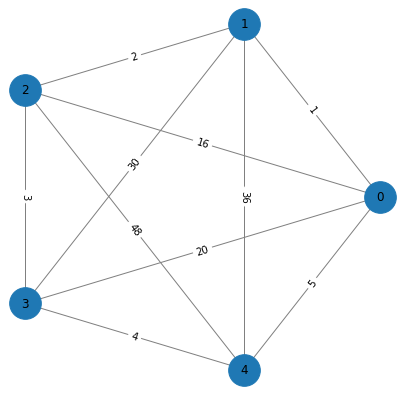

In [460]:
draw_graph(G)

Najkraći put je očito duljine $15$, i to je put $0\rightarrow 1 \rightarrow 2 \rightarrow 3 \rightarrow 4 \rightarrow 0$ (ili bilo koja ciklička rotacija). <br>
Provjerimo koju će rutu odabrati genetički algoritam.

 Najkraća udaljenost je 15 na ruti [2 1 0 4 3]


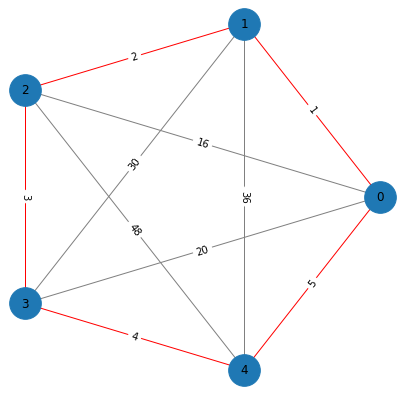

In [444]:
num_of_cities = 5
num_of_routes = 5
num_of_generations = 100

graph = Map(num_of_cities)
dist = np.zeros((5,5), dtype=int)
for edge in G.edges():
    dist[edge[0]][edge[1]] = dist[edge[1]][edge[0]] = G.get_edge_data(*edge)['weight']
graph.distances = dist

path, distances, distance = travel(num_of_cities, num_of_routes, num_of_generations, graph)
print(f' Najkraća udaljenost je {distance} na ruti {path}')
draw_graph(G, path)

### Nasumično odabrani "gradovi"

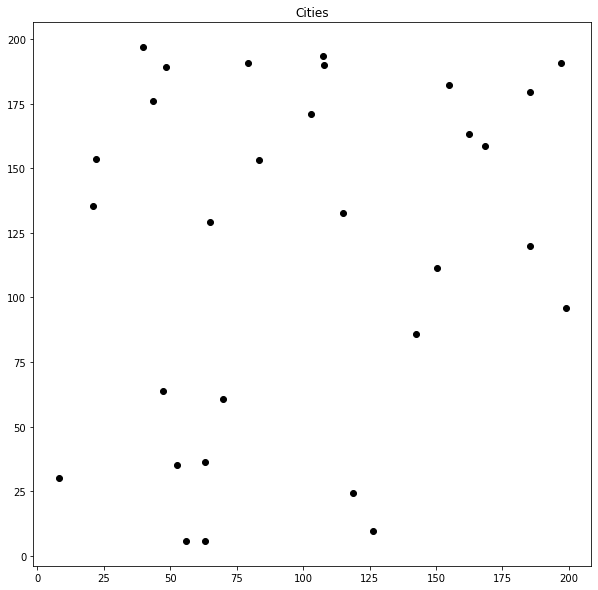

In [461]:
num_of_cities = 30
random_map = Map(num_of_cities, rand = True)
random_map.draw_cities()

In [469]:
num_of_routes = 25
num_of_generations = 1000
random_path, random_distances, random_distance = travel(num_of_cities, num_of_routes, num_of_generations, random_map)

In [482]:
def draw_path(map, path):
    plt.rcParams['figure.figsize'] = [10, 10]
    x = [map.xy[i][0] for i in path]
    x.append(map.xy[path[0]][0])
    y = [map.xy[i][1] for i in path]
    y.append(map.xy[path[0]][1])
    fig, ax = plt.subplots()
    ax.set_title('Best route')
    ax.plot(x,y, marker = 'o', color = 'orange', markeredgecolor = 'black', markerfacecolor = 'black')

In [473]:
def draw_distances_in_generation(distances, num_of_generations):
    plt.rcParams['figure.figsize'] = [12, 8]
    fig, ax = plt.subplots()
    ax.set_title('Distance over generations')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Distance')
    x = np.arange(1, num_of_generations+1)
    ax.plot(x, distances)
    fig

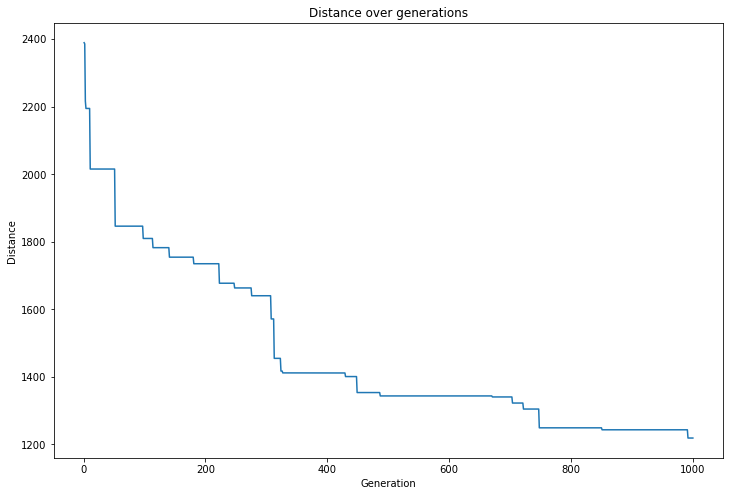

In [474]:
draw_distances_in_generation(random_distances, num_of_generations)

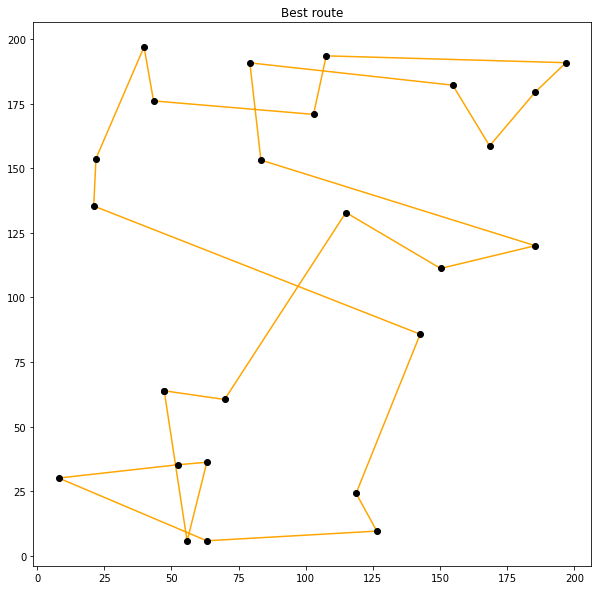

In [483]:
draw_path(random_map, random_path)

### Gradovi na kružnici

In [547]:
num_of_generations_circle = 1000
num_of_cities_circle = 25
num_of_routes_circle = 15
circle_map = Map(num_of_cities_circle)
circle_map.xy = np.array([[math.cos(t), math.sin(t)] for t in np.linspace(0, 2*math.pi, num_of_cities_circle)])
circle_map.distances = circle_map.calculate_distances()

circle_path, circle_distances, circle_distance = travel(num_of_cities_circle, num_of_routes_circle, num_of_generations_circle, circle_map)

Udaljenost između gradova: 14.251956205116265


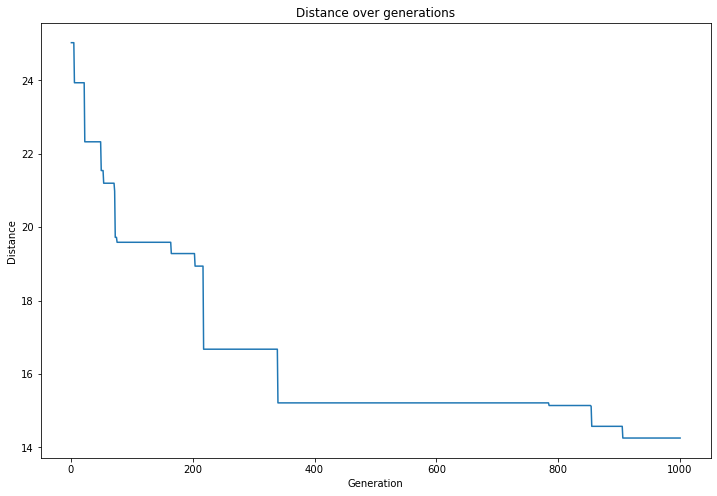

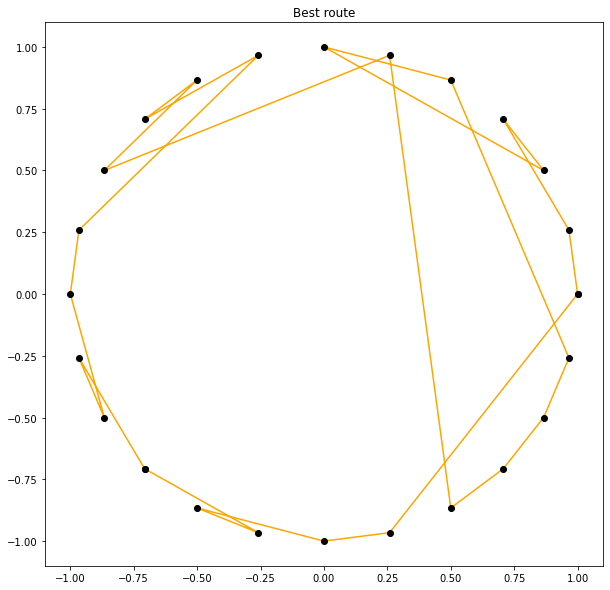

In [550]:
draw_distances_in_generation(circle_distances, len(circle_distances))
draw_path(circle_map, circle_path)
print(f'Udaljenost između gradova: {circle_distances[len(circle_distances)-1]}')

Nakon 5 000 generacija

Udaljenost između gradova: 6.265257226562478


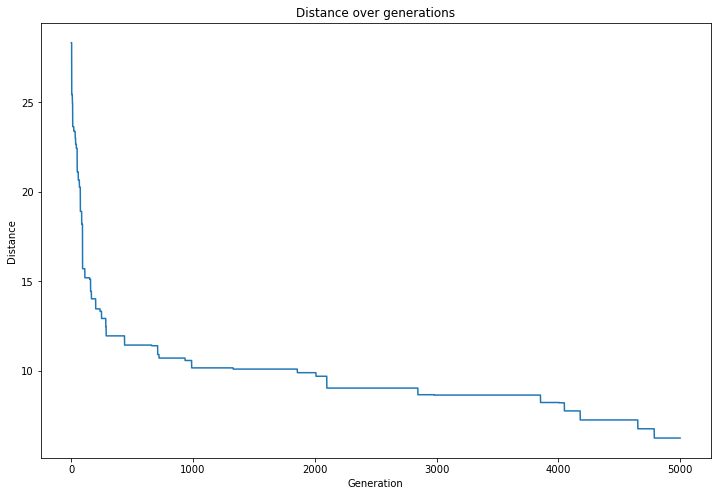

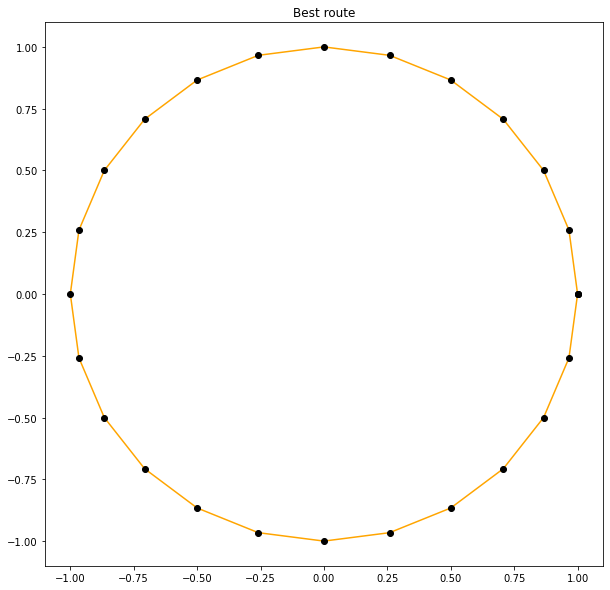

In [536]:
circle_path_load = np.array(np.loadtxt('path_circle.txt'),dtype=int)
circle_dist_load = np.loadtxt('distances_circle.txt')
draw_distances_in_generation(circle_dist_load, len(circle_dist_load))
draw_path(circle_map, circle_path_load)
print(f'Udaljenost između gradova: {circle_dist_load[len(circle_dist_load)-1]}')

### Glavni gradovi američkih saveznih država

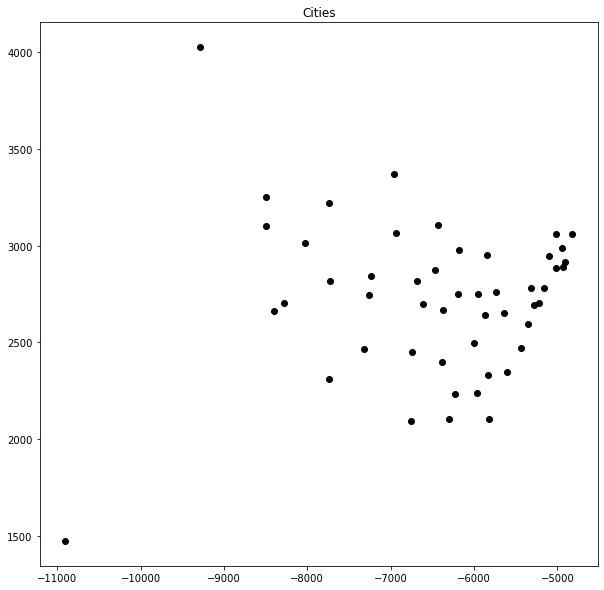

In [489]:
num_of_cities = 50
usa_map = Map(50)
usa_map.xy = np.loadtxt('uscap_xy.txt')
usa_map.distances = map_usa.calculate_distances()
usa_map.draw_cities()

In [507]:
num_of_generations_usa = 1000
usa_path, usa_distances, usa_distance = travel(50, num_of_routes, num_of_generations, usa_map)

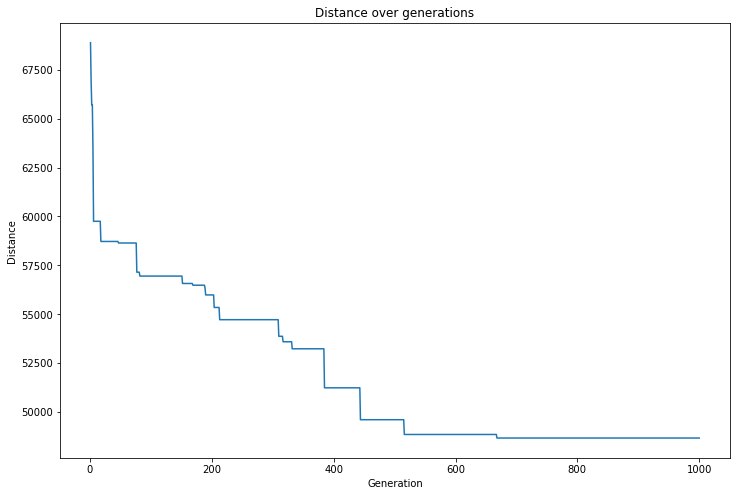

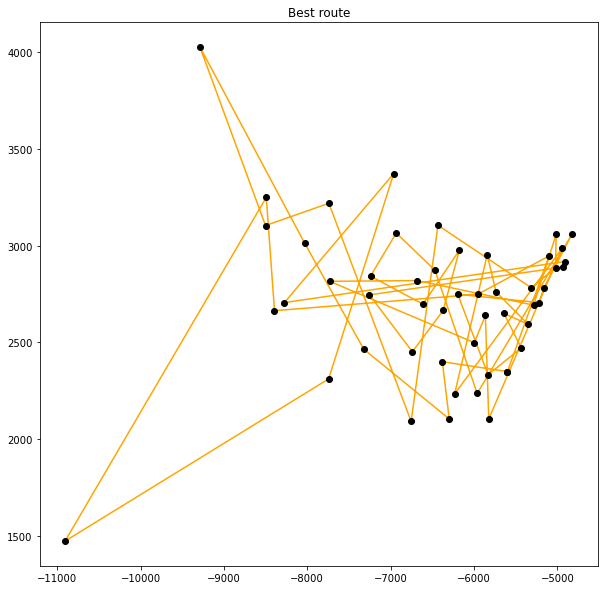

In [524]:
draw_distances_in_generation(usa_distances, num_of_generations_usa)
draw_path(usa_map, usa_path)

ispis gradova prvi_ime -> drugi_ime -> ... -> pedeseti_ime

Ovako to izgleda nakon 1 000 000 generacija:

In [531]:
dst = np.loadtxt('distances_us.txt')
pth = np.array(np.loadtxt('path_us.txt'), dtype = int)

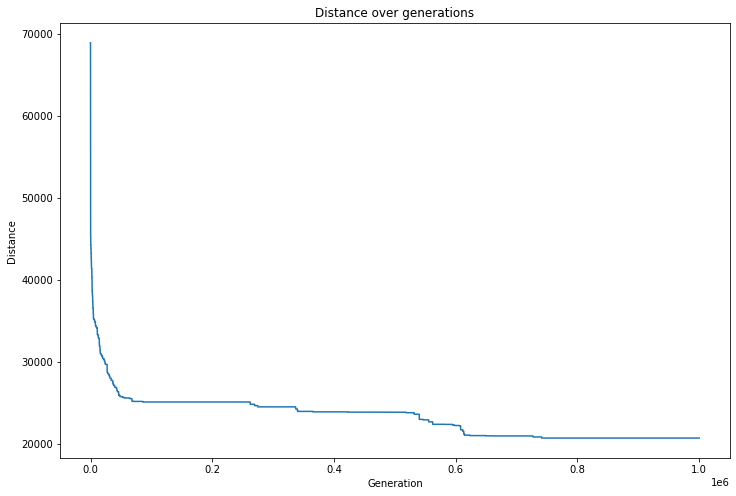

In [532]:
draw_distances_in_generation(dst, len(dst))

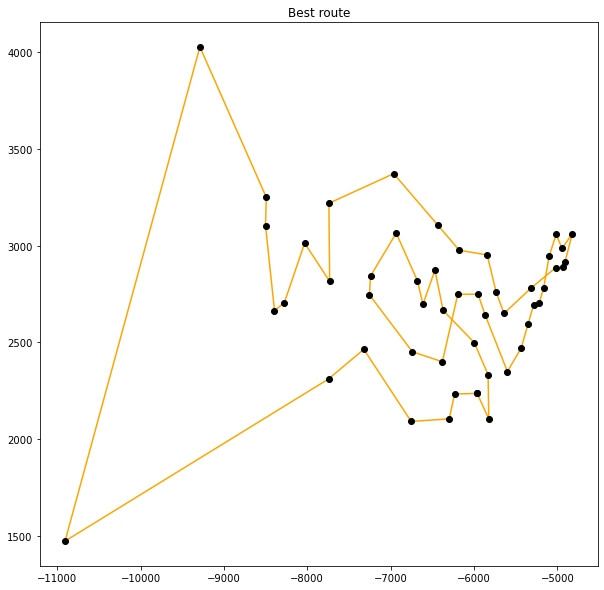

In [533]:
draw_path(usa_map, pth)

# Bibliografija
1. https://www.theprojectspot.com/tutorial-post/applying-a-genetic-algorithm-to-the-travelling-salesman-problem/5
2. https://towardsdatascience.com/genetic-algorithm-explained-step-by-step-65358abe2bf
3. https://en.wikipedia.org/wiki/Genetic_algorithm
4. https://people.sc.fsu.edu/~jburkardt/datasets/cities/cities.html